In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

# used to look at images
from skimage import io, color, filters, feature
from skimage.transform import resize, rotate
from PIL import Image, ImageOps
import cv2 as cv

# to read in the .mat files
import scipy.io as sio 


# tensorflow - for CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model

# used to import the image folders
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

from tensorflow.keras.models import Model, load_model
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization

from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess


from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# set DataFrame viewing options to show the whole data frame
pd.set_option('display.max_rows', None, "display.max_columns", None)


### Used the train_list.mat file to create dictionary of label names and class names

In [3]:
train_dict = sio.loadmat('extras/lists/train_list.mat')

In [4]:
# use regex to create list of breed names from train_dict
breeds = []
for i in np.unique(train_dict['labels']):
    # get one file - first 0 is just first file with the label
    # second 0 is just the file path
    file = train_dict['file_list'][train_dict['labels'] == i][0][0]
    # regex pattern
    # n[0-9]+- denotes a pattern that starts with n, has the group 0-9 an unknown amount of times and a hyphen
    # OR a pattern that starts with non-whitespace (\W for the forward slash), n[0-9]+, an underscore
    # [0-9] some amount of times and ends with .jpg
    pattern = re.compile(r'n[0-9]+-|\Wn[0-9]+_[0-9]+.jpg')
    # replace this pattern for each file with an empty string and append to breeds list
    breeds.append(pattern.sub('', file))

In [5]:
# create empty dictionary for labels
breed_key = dict()
for i in np.unique(train_dict['labels']):
    # labels start at 1, so to match python idx, subtract 1 from i for both
    breed_key[i-1] = breeds[i-1]
    
# breed_key

### Load in the images and place them into the appropriate batches

In [6]:
train_path1 = 'extras/Images/train1'
train_path2 = 'extras/Images/train2'
train_path3 = 'extras/Images/train3'
train_path4 = 'extras/Images/train4'
train_path5 = 'extras/Images/train5'
# train_path = 'extras/Images_copy/train'

valid_path = 'extras/Images/valid'
test_path = 'extras/Images/test'

## Creating VGG16 model

In [ ]:
# transfer learning model
inceptionresnetv2_model = tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [ ]:
# freeze layers that have already been trained
for layer in inceptionresnetv2_model.layers[:-1]:
    layer.trainable = False

In [ ]:
# adding new model on top
inputs = Input(shape = (224, 224, 3))
x = inceptionresnetv2_model(inputs, training = False)
# converts features of shape of model's amount of rows to vectors
x = GlobalAveragePooling2D()(x)

# create expected output layer - final prediction layer (dense) to predict the 120 classes
output = Dense(120, activation = 'softmax')(x)

# put it all together
dog_classifier_model = Model(inputs, output)

In [ ]:
dog_classifier_model.summary()

In [7]:
# this is the augementation used for training, testing, and validation data
# consider changing the pixels to be 0-1 in ImageDataGenerator
datagen = image.ImageDataGenerator()
datagen_training = image.ImageDataGenerator(validation_split=0.1, preprocessing_function=preprocess_input)


# train_batch = datagen.flow_from_directory(train_path, target_size = (224, 224),
#                                           classes = breeds, batch_size = 5)


# Make smaller training batches for sake of computer
train_batch1 = datagen_training.flow_from_directory(train_path1, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch2 = datagen_training.flow_from_directory(train_path2, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch3 = datagen_training.flow_from_directory(train_path3, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch4 = datagen_training.flow_from_directory(train_path4, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch5 = datagen_training.flow_from_directory(train_path5, target_size = (224, 224),
                                          classes = breeds, batch_size = 5,
                                          subset = 'training', seed = 42)

# respective validation batches of training batches
valid_batch1 = datagen_training.flow_from_directory(train_path1, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch2 = datagen_training.flow_from_directory(train_path2, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch3 = datagen_training.flow_from_directory(train_path3, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch4 = datagen_training.flow_from_directory(train_path4, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch5 = datagen_training.flow_from_directory(train_path5, target_size = (224, 224),
                                          classes = breeds, batch_size = 5,
                                          subset = 'validation', seed = 42)

test_batch = datagen.flow_from_directory(test_path, target_size = (224, 224),
                                        classes = breeds, batch_size = 5, shuffle = False)

Found 3054 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 272 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 4122 images belonging to 120 classes.


In [ ]:
# compile model
# used gradient descent as optimizer
optimizer = Adam(lr = 0.0001)
dog_classifier_model.compile(optimizer = optimizer,
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

# Stops training if validation loss doesn't improve
callback = EarlyStopping(monitor = 'val_loss', patience = 3)

In [ ]:
# batch_size = 32 is good starting point
# steps_per_epoch = training_size / batch_size
dog_classifier_model.fit(train_batch1, validation_data = valid_batch1, epochs = 8, callbacks = callback, verbose = 2)

In [ ]:
dog_classifier_model.fit(train_batch2, validation_data = valid_batch2, epochs = 8, callbacks = callback, verbose = 2)

In [ ]:
dog_classifier_model.fit(train_batch3, validation_data = valid_batch3, epochs = 8, callbacks = callback, verbose = 2)

In [ ]:
dog_classifier_model.fit(train_batch4, validation_data = valid_batch4, epochs = 8, callbacks = callback, verbose = 2)

In [ ]:
dog_classifier_model.fit(train_batch5, validation_data = valid_batch5, epochs = 8, callbacks = callback, verbose = 2)

In [ ]:
# save the model
dog_classifier_model.save('dog_classifier_model.h5')

In [ ]:
# transfer learning model
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
vgg16_dog_classifier_model = Sequential()

for layer in vgg16_model.layers[:-1]:
    vgg16_dog_classifier_model.add(layer)

In [ ]:
# freeze layers that have already been trained
for layer in vgg16_dog_classifier_model.layers[:-1]:
    layer.trainable = False

In [ ]:
# create expected output layer - final prediction layer (dense) to predict the 120 classes
vgg16_dog_classifier_model.add(Dense(120, activation = 'softmax'))

In [ ]:
vgg16_dog_classifier_model.summary()

In [8]:
# this is the augementation used for training, testing, and validation data
# consider changing the pixels to be 0-1 in ImageDataGenerator
datagen = image.ImageDataGenerator()
datagen_training = image.ImageDataGenerator(validation_split = 0.1, preprocessing_function = vgg16_preprocess)


# train_batch = datagen.flow_from_directory(train_path, target_size = (224, 224),
#                                           classes = breeds, batch_size = 5)


# Make smaller training batches for sake of computer
train_batch1_vgg16 = datagen_training.flow_from_directory(train_path1, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch2_vgg16 = datagen_training.flow_from_directory(train_path2, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch3_vgg16 = datagen_training.flow_from_directory(train_path3, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch4_vgg16 = datagen_training.flow_from_directory(train_path4, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'training', seed = 42)
train_batch5_vgg16 = datagen_training.flow_from_directory(train_path5, target_size = (224, 224),
                                          classes = breeds, batch_size = 5,
                                          subset = 'training', seed = 42)

# respective validation batches of training batches
valid_batch1 = datagen_training.flow_from_directory(train_path1, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch2_vgg16 = datagen_training.flow_from_directory(train_path2, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch3_vgg16 = datagen_training.flow_from_directory(train_path3, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch4_vgg16 = datagen_training.flow_from_directory(train_path4, target_size = (224, 224),
                                          classes = breeds, batch_size = 5, 
                                          subset = 'validation', seed = 42)
valid_batch5_vgg16 = datagen_training.flow_from_directory(train_path5, target_size = (224, 224),
                                          classes = breeds, batch_size = 5,
                                          subset = 'validation', seed = 42)

test_batch_vgg16 = datagen.flow_from_directory(test_path, target_size = (224, 224),
                                        classes = breeds, batch_size = 5, shuffle = False)

Found 3054 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 3009 images belonging to 120 classes.
Found 272 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 274 images belonging to 120 classes.
Found 4122 images belonging to 120 classes.


In [ ]:
# compile model
# used gradient descent as optimizer
optimizer = Adam(lr = 0.0001)
vgg16_dog_classifier_model.compile(optimizer = optimizer,
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

# Stops training if validation loss doesn't improve
callback = EarlyStopping(monitor = 'val_loss', patience = 3)

In [ ]:
# batch_size = 32 is good starting point
# steps_per_epoch = training_size / batch_size
vgg16_dog_classifier_model.fit(train_batch1_vgg16, validation_data = valid_batch1_vgg16, epochs = 8, callbacks = callback)

In [ ]:
vgg16_dog_classifier_model.fit(train_batch2_vgg16, validation_data = valid_batch2_vgg16, epochs = 8, callbacks = callback)

In [ ]:
vgg16_dog_classifier_model.fit(train_batch3_vgg16, validation_data = valid_batch3_vgg16, epochs = 8, callbacks = callback)

In [ ]:
vgg16_dog_classifier_model.fit(train_batch4_vgg16, validation_data = valid_batch4_vgg16, epochs = 8, callbacks = callback)

In [ ]:
vgg16_dog_classifier_model.fit(train_batch5_vgg16, validation_data = valid_batch5_vgg16, epochs = 8, callbacks = callback)

In [ ]:
vgg16_dog_classifier_model.save('vgg16_dog_classifier_model.h5')

In [9]:
# load vgg16 model
vgg16_dog_classifier = load_model('vgg16_dog_classifier_model.h5')

In [10]:
prediction_vgg16 = vgg16_dog_classifier.predict(test_batch_vgg16)

In [11]:
pred_vgg16_df = pd.DataFrame(prediction_vgg16, columns = breeds)

In [12]:
# load inception model
dog_classifier_model = load_model('dog_classifier_model.h5')

In [13]:
# predictions
predictions = dog_classifier_model.predict(test_batch)

In [14]:
pred_incep_df = pd.DataFrame(predictions, columns = breeds)

In [15]:
decode_vgg16 = tf.argmax(pred_vgg16_df, axis = 1)
labels_vgg16 = []
for i in np.array(decode_vgg16):
    labels_vgg16.append(breed_key[i])

In [16]:
decode_incep = tf.argmax(pred_incep_df, axis = 1)
labels_incep = []

for i in np.array(decode_incep):
    labels_incep.append(breed_key[i])

In [ ]:
# we can see that inception resnet v3 overfits the model
np.unique(np.array(decode_incep))

In [ ]:
np.unique(np.array(decode_vgg16))

In [17]:
y_true_vgg16 = []
y_true_incep = []
for i in range(len(test_batch.classes)):
    y_true_vgg16.append(breeds[test_batch_vgg16.classes[i]])
    y_true_incep.append(breeds[test_batch.classes[i]])

In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score

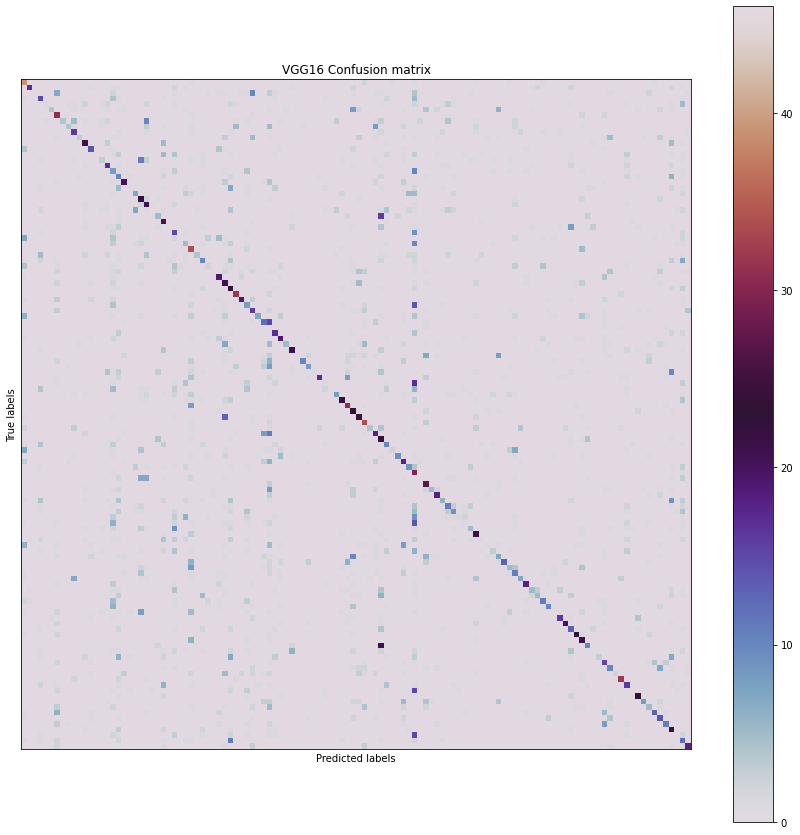

In [27]:
cm = confusion_matrix(y_true_vgg16, labels_vgg16)
fig, ax = plt.subplots(figsize = (15, 15))
plt.imshow(cm, cmap = 'twilight')
plt.xlabel('Predicted labels')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([],[])
plt.yticks([],[])
plt.title('VGG16 Confusion matrix')
plt.colorbar()
plt.savefig('img/vgg16_Confusion_Matrix.jpg');

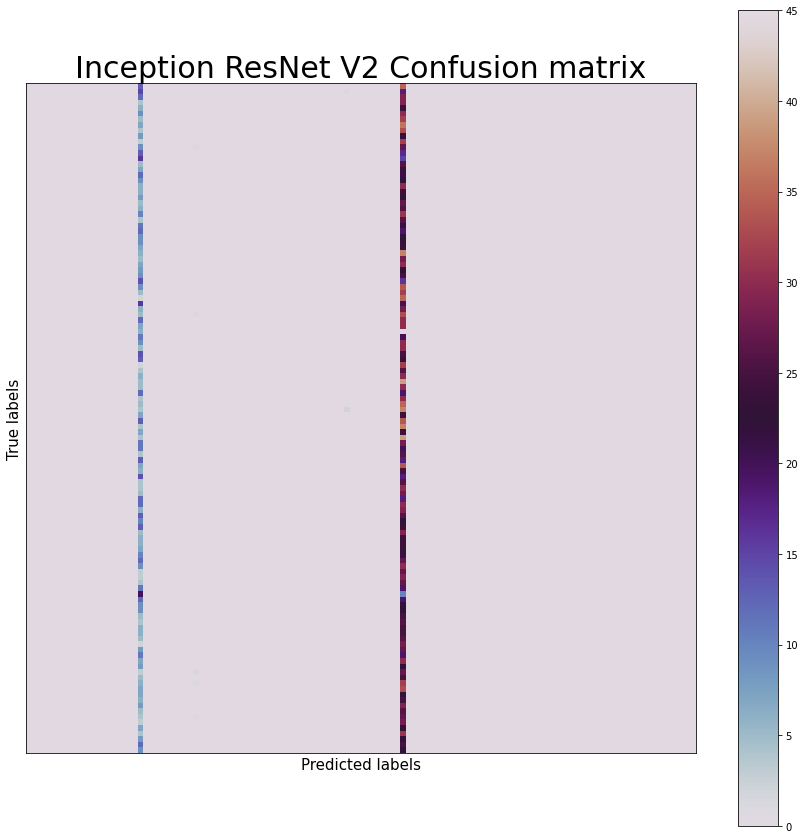

In [31]:
cm = confusion_matrix(y_true_incep, labels_incep)
fig, ax = plt.subplots(figsize = (15, 15))
plt.imshow(cm, cmap = 'twilight')
plt.xlabel('Predicted labels', size = 15)
plt.ylabel('True labels', size = 15)
plt.xticks([],[])
plt.yticks([],[])
plt.title('Inception ResNet V2 Confusion matrix', size = 30)
plt.colorbar()
plt.savefig('img/incep_Confusion_Matrix.jpg');

In [ ]:
np.unique(labels_incep)

In [21]:
vgg_acc = accuracy_score(y_true_vgg16, labels_vgg16)
irnv2_acc = accuracy_score(y_true_incep, labels_incep)
print(f"Probability of Choosing Breed Correctly at Random: {1/120}\nVGG16 Accuracy: {vgg_acc}\nInception ResNet V2 Accuracy: {irnv2_acc}")

Probability of Choosing Breed Correctly at Random: 0.008333333333333333
VGG16 Accuracy: 0.3529839883551674
Inception ResNet V2 Accuracy: 0.006307617661329452


In [22]:
from src.helper_functions import *

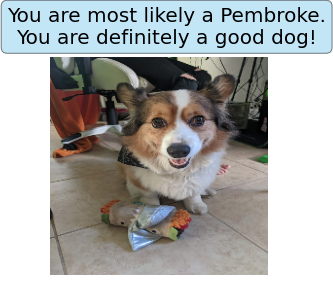

In [23]:
vgg_breed_predict('extras/demo/Thor3.jpg', breeds)

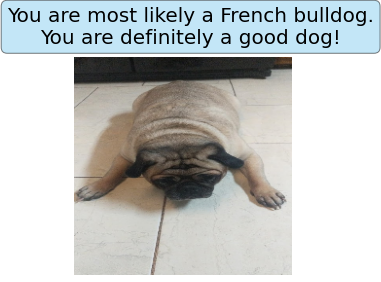

In [25]:
vgg_breed_predict('extras/demo/loaf.jpg', breeds)

In [ ]:
inception_breed_predict('extras/demo/loaf.jpeg', breeds)

In [ ]:
vgg_breed_predict('extras/demo/shawns.jpeg', breeds)

In [ ]:
vgg_breed_predict('extras/demo/shawns2.jpg', breeds)